# Final Project

<p> This IPython notebook looks at the Mental Health Partners (MHP) Dataset for interesting observations/findings.<br>
The files <i>CCARs.xlsx</i> and <i>Services.xlsx</i> are used for the analysis.</p>

### Importing the dataset into two dataframes ccars and services

In [2]:
# Importing all required libraries

import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image
import pydotplus
import statsmodels.stats.proportion
from sklearn import metrics


%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
ccars = pd.read_excel('CCARs.xlsx')
services = pd.read_excel('Services.xlsx')
# the code above will take a long time to run, because the files are large

## Summary #1 : 
1. People who feel hopeless ('HOPE' > 6) are more likely to file a claim within 30 days of a CCAR assessment compared to others ('HOPE' <= 6).
2. People aged between 15 and 25 have a higher likelihood (23.6%) of filing a claim within 30 days of a CCAR assessment irrespective of how hopeful they feel compared to people of other ages (13.5%).

## Data Cleansing

In [4]:
# Merging the two datasets: ccar and services
mergedf = ccars.merge(services,left_on='CLIENT_ID',right_on='CLIENT_ID')

In [5]:
mergedf['DAYS_TO_SERVICE'] = mergedf['SERVICE_DATE'] - mergedf['CCAR_DATE']
mergedf['CLAIM'] = (mergedf['SOURCE'] == 'Claim').astype(int)
df = mergedf[['CLIENT_ID','HOUSING','LEVEL_OF_FUNCTIONING','SYMPTOM_SEVERITY','HOPE','DAYS_TO_SERVICE',\
             'MBR_AGE','MBR_GENDER','MEDICAID_ELIG_CAT','CLAIM']]
#Retaining only rows where DAYS_TO_SERVICE is between 0 and 30
df = df[(df['DAYS_TO_SERVICE'] >= '0') & (df['DAYS_TO_SERVICE'] <= '30 days')]
#Dropping unwanted columns
df.drop(['DAYS_TO_SERVICE','CLIENT_ID'],axis=1,inplace=True)

We only consider those data points where there is either a claim or an encounter by a patient within 30 days of a CCAR assessment. We want to build a machine learning model that accurately predicts a claim within 30 days of a CCAR assessment.

In [6]:
#Adding dummy columns for categorical variables etc.
X = pd.get_dummies(data=df,columns=['MBR_GENDER','MEDICAID_ELIG_CAT',\
                                   'HOUSING'])
Y = X.CLAIM
X.drop('CLAIM',axis=1,inplace=True)

## Validity of the finding

In [7]:
df['MBR_AGE.BIN'] = pd.cut(df['MBR_AGE'],bins=[0,15,25,35,45,60,75],include_lowest=True)
df['HOPELESS'] = (df['HOPE'] > 6).astype(int)

The chart below shows that the claims rate for people who feel hopeless ('HOPE' > 6) is higher. Infact the probability of a hopeless person filing a claim is about 20.6% compared to 14.3% for a hopeful person. This is also statistically significant as seen from the confidence intervals. 

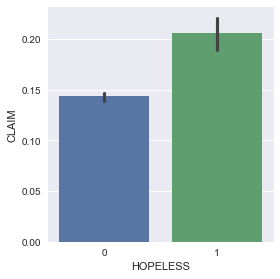

In [8]:
sns.factorplot(x='HOPELESS',y='CLAIM',data=df,aspect=1,kind='bar')

In [9]:
hopeless = ((df['CLAIM'] == 1) & (df['HOPELESS'] == 1)).sum()
hopeful = ((df['CLAIM'] == 1) & (df['HOPELESS'] == 0)).sum()
hopelessTotal = ((df['HOPELESS'] == 1)).sum()
hopefulTotal = ((df['HOPELESS'] == 0)).sum()
print hopeless, hopeful, hopelessTotal, hopefulTotal

conf0 = statsmodels.stats.proportion.proportion_confint(count=hopeless,nobs=hopelessTotal)
conf1 = statsmodels.stats.proportion.proportion_confint(count=hopeful,nobs=hopefulTotal)
print "The confidence interval for the probability of a hopeless person filing a claim is (%f , %f)"%conf0
print "The confidence interval for the probability of a non-hopeless person filing a claim is (%f , %f)"%conf1

512 4555 2490 31778
The confidence interval for the probability of a hopeless person filing a claim is (0.189748 , 0.221497)
The confidence interval for the probability of a non-hopeless person filing a claim is (0.139485 , 0.147191)


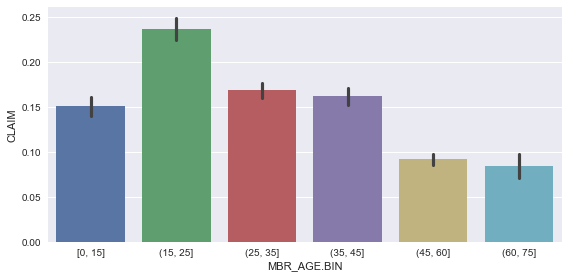

In [10]:
sns.factorplot(y='CLAIM',x='MBR_AGE.BIN',data=df,aspect=2,kind='bar')

The chart above shows that people aged between 15 to 25 have a significantly higher probability of filing a claim within 30 days irrespective of how hopeful/hopeless they feel. Infact the probability of a claim within 30 days for this group is 23.6% compared to the rest of the age groups at 13.5%, and this is statistically significant as seen from the confidence intervals.

In [11]:
age_15to25 = ((df['MBR_AGE.BIN'] == '(15, 25]') & (df['CLAIM'] == 1)).sum()
otherAges = ((df['MBR_AGE.BIN'] != '(15, 25]') & (df['CLAIM'] == 1)).sum()
age_15to25Total = ((df['MBR_AGE.BIN'] == '(15, 25]')).sum()
otherAgesTotal = ((df['MBR_AGE.BIN'] != '(15, 25]')).sum()

conf0 = statsmodels.stats.proportion.proportion_confint(count=age_15to25,nobs=age_15to25Total)
conf1 = statsmodels.stats.proportion.proportion_confint(count=otherAges,nobs=otherAgesTotal)
print "The confidence interval for the probability of a person aged 15 to 25 filing a claim is (%f, %f)"%conf0
print "The confidence interval for the probability of a person in other age groups filing a claim is (%f, %f)"%conf1

The confidence interval for the probability of a person aged 15 to 25 filing a claim is (0.223724, 0.248598)
The confidence interval for the probability of a person in other age groups filing a claim is (0.130709, 0.138460)


## Machine Learning

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

clfs = [DecisionTreeClassifier(), sk.ensemble.RandomForestClassifier(n_jobs=-1), sk.naive_bayes.GaussianNB(),
        sk.linear_model.LogisticRegression(n_jobs=-1),sk.tree.DecisionTreeClassifier(),sk.ensemble.AdaBoostClassifier(),
        QuadraticDiscriminantAnalysis(),MLPClassifier(),SVC()]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25,random_state=0)

In [14]:
maxAUC = -1
bestCL = ''
for cl in clfs:
    kf = KFold(n_splits = 10, random_state = 2, shuffle=True)
    cv_auc = cross_val_score(cl,X_train,y=Y_train,scoring='roc_auc',cv=kf).mean()
    if cv_auc > maxAUC:
        maxAUC = cv_auc
        bestCL = cl
print bestCL
print maxAUC

C:\Users\ronathan\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.937259358796


The best classifier is RandomForest with an AUC score of 0.94 for the training data set. To verify if there is any overfitting, we find out what the value is on the test dataset

In [15]:
bestCL.fit(X_train,Y_train)
y_proba = bestCL.predict_proba(X_test)
print roc_auc_score(Y_test,y_proba[:,1])

0.947899390146


We see that the AUC score for the test dataset is 0.94 which is comparable. As the next step, let us list down the features/attributes in the model based on feature importance values to see which feature is the most important.

In [16]:
importances = bestCL.feature_importances_
imp1 = pd.DataFrame(importances,X.columns,['Importances']).sort_values('Importances',ascending=False)
imp1[imp1['Importances'] > 0]

,Importances
MBR_AGE,0.411530
HOPE,0.159809
LEVEL_OF_FUNCTIONING,0.154156
SYMPTOM_SEVERITY,0.127731
MEDICAID_ELIG_CAT_DISABLED,0.021007
HOUSING_15,0.017039
MBR_GENDER_Female,0.014587
MBR_GENDER_Male,0.012274
HOUSING_12,0.011730
MEDICAID_ELIG_CAT_AwDC,0.011225


From this table, we can see that the Age and Hope are two of the top attributes identified by the machine learning model. We use this as a starting point to see how the likelihood of claims within 30 days vary with respect to Age and Hope levels.

## Summary #2 : The average cost of a claim for Opioid Depedence (SUD) is only $18, so clients prefer IPNs, specifically BHG Longmont over MHP

## Data Cleansing

In [17]:
# Adding columns to the SERVICES dataset
services['CLAIM'] = (services['SOURCE'] == 'Claim').astype(int)
services['CHARGED_AMT_ENC'] = np.where(services['CLAIM']==0, services['CHARGED_AMT'], np.NaN)
services['CHARGED_AMT_CLAIM'] = np.where(services['CLAIM']==1, services['CHARGED_AMT'], np.NaN)

# Creating a new dataframe with dummy columns for building decision tree
services1 = pd.get_dummies(data=services,columns=['MBR_GENDER','SERVICE_TYPE','MEDICAID_ELIG_CAT',\
                                                'DIAGNOSIS'])

# Dropping unwanted columns in services1
services1.drop(['CLIENT_ID','SERVICE_DATE','SERVICE_CODE','SERV_CODE_DESCRP','ADMISSION_DATE','DISCHARGE_DATE','PROVIDER',\
                'PRV_TYP_DESC','PROV_CREDENTIALS','PROV_ZIPCODE','PROV_FLAG','PAID_AMT','SERVICE_DURATION',\
               'SERVICE_UNITS','MBR_ZIPCODE','SOURCE','CHARGED_AMT_CLAIM','CHARGED_AMT_ENC',\
               'MBR_PRIMARY_LANGUAGE'], inplace=True,axis=1)
X = services1.drop(['CLAIM','CHARGED_AMT'],axis=1)
Y = services1.CLAIM
X.replace(' ',np.NaN,inplace=True)

## Validity of the finding

From the dataset it can be seen that the volume of claims falling under SUD type services is significantly higher contributing to higher percentage of claims overall. Drilling down further within SUD service type, we see the diagnosis that's contributing to higher percentage of claims and the corresponding average costs associated with the service. The table below shows the top 5 diagnosis that falls under SUD service, the number of encounters and claims for these diagnosis and their corresponding costs.

In [18]:
diag = services.groupby('DIAGNOSIS',as_index=False)['CHARGED_AMT_ENC','CHARGED_AMT_CLAIM','CLAIM']\
.agg({'CHARGED_AMT_ENC' : {'Encounter' : {'count','mean'}},'CHARGED_AMT_CLAIM' : {'Claim' : {'count','mean'}},\
     'CLAIM' : {'Proportion of Claims' : {'mean'}}})
diag.sort_values([('Claim', 'count')],ascending=False).head(5)

DIAGNOSIS Encounter              \
                                                     count        mean   
252             Opioid Dependence, Uncomplicated      2992  154.075201   
253           Opioid Type Dependence, Continuous         0         NaN   
39             Alcohol Dependence, Uncomplicated     14855  124.979536   
331  Post-Traumatic Stress Disorder, Unspecified     17415  215.550991   
191                         Illness, Unspecified      1890  156.717497   

    Proportion of Claims  Claim              
                    mean  count        mean  
252             0.953127  60840   18.757940  
253             1.000000   7778   16.990494  
39              0.195549   3611   70.070770  
331             0.125358   2496  290.395329  
191             0.549786   2308  159.243263

In [19]:
#Considering diagnosis where there are at least 100 claims to get rid of outliers
diag = diag[(diag[('Claim','count')] >= 100)]
corr = diag[('Proportion of Claims','mean')].corr(diag[('Claim','mean')])
print "The correlation between the average cost of claims for a diagnosis and the proportion of claims for the diagnosis is %f"%corr
print "The negative correlation indicates there is a general tendency to go for a claim if the costs are not as high"

The correlation between the average cost of claims for a diagnosis and the proportion of claims for the diagnosis is -0.294454
The negative correlation indicates there is a general tendency to go for a claim if the costs are not as high


It can be seen from the table above that the Opioid Dependence tops the chart with as many as 60,840 claims which is more than 50% of all claims. Furthermore, the average cost of such claims is only about \$18 which is not very expensive compared to other claims. This can be seen from the graph below where the cost of claims for "Opioid Dependence, Uncomplicated" is much lower than the cost of claims for all other services. Correspondingly, as the average cost of claims increase from \$18 to \$70 and above for Alcohol Dependence, PTST etc. the corresponding claims to encounters ratio also decreases which is indicated by the negative correlation. 

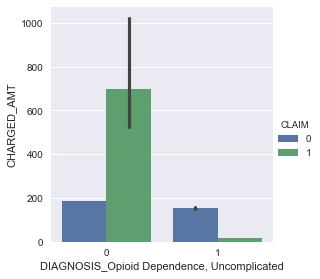

In [20]:
sns.factorplot(y='CHARGED_AMT',x='DIAGNOSIS_Opioid Dependence, Uncomplicated',hue='CLAIM',\
              data=services1,aspect=1,kind='bar')

It appears that these clients prefer other healthcare providers (IPNs) (even though they have to pay out of pocket upfront) since the service is not as expensive. To drill down further as to which service provider is sought after by these clients, we look into the top healthcare providers that service clients with Opioid dependence. From the table below, it is clear that clients are mostly served by BHG Longmont leaving MHP (in-network provider) at a distant fifth place.

In [21]:
services[services['DIAGNOSIS'] == 'Opioid Dependence, Uncomplicated'].groupby('PROVIDER')['CLIENT_ID','CHARGED_AMT']\
.agg({'CLIENT_ID' : {'Services' : 'count'}, 'CHARGED_AMT' : {'Avg. Charge' : 'mean'}})\
.nlargest(5,'Services',keep='first')

,Avg. Charge,Services
PROVIDER,,
BHG LONGMONT TREATMENT CENTER,15.832674,41972
BHG WESTMINSTER TREATMENT CENTER,15.388048,9321
REGENTS OF THE UNIVERSITY OF COLORA,14.594563,4284
DENVER HEALTH MEDICAL CENTER,55.781761,3435
MENTAL HEALTH PARTNERS,154.083584,2991


### Recommendation to Management

 One recommendation to MHP management is to explore the possibility of partnering with BHG such that clients can avail in-network service at these treatment centers and reduce the overhead of claims processing and reimbursements.

## Machine Learning

The above finding was detected by building the following decision tree based on the SERVICES dataset. A seen below, the first split is based on "Opioid Dependence, Uncomplicated". Hence, I decided to explore the role of this attribute further to understand what influences clients with this condition to go for IPNs.

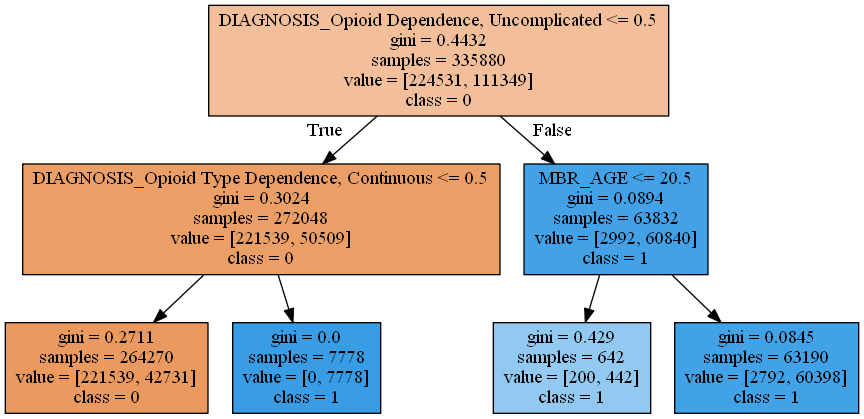

In [22]:
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X,Y)

dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())